### Let's start by unzipping the folder

In [27]:
# Run this in a code cell in your notebook
!pip install timm
!pip install torch torchvision torchaudio
!pip install seaborn scikit-learn tqdm pillow matplotlib

In [3]:
#requirments
import os
import zipfile

In [9]:
# data.zip is in the current directory
zip_path = 'data.zip'

# Define extraction directory 
extract_dir = '.'

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
    
# This step is for debug only 
# Prints the  
print(f"Extracted files and directories:")
for item in os.listdir(extract_dir):
    if item != 'data.zip' and item != '.ipynb_checkpoints' and item != 'main.ipynb' and item != 'ee6892_final_project':
        print(f"- {item}")

Extracted files and directories:
- data


### Analyze the training directory

In [20]:
import os

def analyze_directory(path, indent=0):
    """Recursively analyze a directory and its contents"""
    print(" " * indent + f" {os.path.basename(path)}/")
    
    # try:
    #     contents = os.listdir(path)
    # except PermissionError:
    #     print(" " * (indent + 2) + "Permission denied")
    #     return
    
    # Separate directories and files
    
    directories = []
    files = []
    
    for item in contents:
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            directories.append(item)
        else:
            files.append(item)
    
    # Process subdirectories first (recursively)
    for directory in sorted(directories):
        analyze_directory(os.path.join(path, directory), indent + 2)
    
    # List files (summarize if there are many)
    if files:
        file_count = len(files)
        if file_count <= 10:
            for file in sorted(files):
                print(" " * (indent + 2) + f" {file}")
        else:
            # Show a few files and summarize the rest
            for file in sorted(files)[:5]:
                print(" " * (indent + 2) + f"{file}")
            print(" " * (indent + 2) + f"... and {file_count - 5} more files")
            
            # Show file extensions summary
            extensions = {}
            for file in files:
                ext = os.path.splitext(file)[1].lower() or "no extension"
                extensions[ext] = extensions.get(ext, 0) + 1
            
            print(" " * (indent + 2) + "File types:")
            for ext, count in sorted(extensions.items(), key=lambda x: x[1], reverse=True):
                print(" " * (indent + 4) + f"{ext}: {count} files")

# Find any data-related directories
data_dirs = []
for item in os.listdir('.'):
    if os.path.isdir(item) and item not in ['.ipynb_checkpoints', 'ee6892_final_project']:
        data_dirs.append(item)

if not data_dirs:
    print("No data directories found in the current working directory.")
else:
    print("Complete directory structure of extracted data:")
    for dir_path in sorted(data_dirs):
        analyze_directory(dir_path)

Complete directory structure of extracted data:
 data/
   test/
     Cataract/
      1083_left.jpg
      1144_left.jpg
      1460_right.jpg
      1968_left.jpg
      1987_left.jpg
      ... and 99 more files
      File types:
        .jpg: 98 files
        .png: 6 files
     DR/
      e4e343eaae2a.png
      e4f12411fd85.png
      e52ed5c29c5e.png
      e540d2e35d15.png
      e55188915f9d.png
      ... and 162 more files
      File types:
        .png: 167 files
     Glaucoma/
      1214_right.jpg
      1222_left.jpg
      1227_right.jpg
      1232_right.jpg
      1248_left.jpg
      ... and 126 more files
      File types:
        .jpg: 119 files
        .png: 12 files
     Normal/
      e4dcca36ceb4.png
      e50b0174690d.png
      e5197d77ec68.png
      e529c5757d64.png
      e582e56e7942.png
      ... and 266 more files
      File types:
        .png: 199 files
        .jpg: 72 files
   train/
     Cataract/
      0_left.jpg
      103_left.jpg
      1084_right.jpg
      1102_left.jp

# Import Libraries and Setup

In [8]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Set up directories
data_dir = "./data"
save_dir = "./models"
results_dir = "./results"
os.makedirs(save_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set hyperparameters
batch_size = 32
img_size = 224
num_classes = 4  # Cataract, DR, Glaucoma, Normal
ssl_epochs = 5    # Reduced for testing
finetune_epochs = 5  # Reduced for testing
kd_epochs = 10   # Reduced for testing
lr = 1e-4
weight_decay = 1e-4

# Define class names
class_names = ['Cataract', 'DR', 'Glaucoma', 'Normal']

print("Setup complete!")

Using device: cuda
Setup complete!


# Load and Analyze Dataset

Loading datasets...

Dataset Information:
Train set size: 4997 images
Val set size: 1057 images
Test set size: 673 images

Analyzing class distribution...

Train set class distribution:
  Normal: 1923 images (38.5%)
  Glaucoma: 878 images (17.6%)
  DR: 1496 images (29.9%)
  Cataract: 700 images (14.0%)

Val set class distribution:
  Cataract: 234 images (22.1%)
  DR: 194 images (18.4%)
  Glaucoma: 294 images (27.8%)
  Normal: 335 images (31.7%)

Test set class distribution:
  Cataract: 104 images (15.5%)
  DR: 167 images (24.8%)
  Glaucoma: 131 images (19.5%)
  Normal: 271 images (40.3%)

Visualizing sample images...


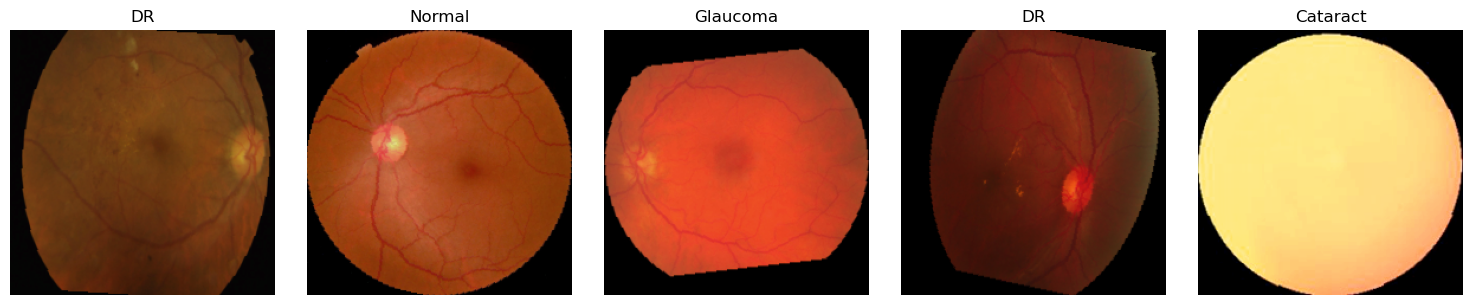

Dataset analysis complete!


In [10]:
# Import data utilities
from data_utils import get_dataloaders, visualize_dataset_samples, get_class_distribution

# Load datasets
print("Loading datasets...")
dataloaders = get_dataloaders(
    data_dir=data_dir,
    batch_size=batch_size,
    img_size=img_size,
    num_workers=4
)

# Display dataset information
print("\nDataset Information:")
for split in ['train', 'val', 'test']:
    print(f"{split.capitalize()} set size: {len(dataloaders[split].dataset)} images")

# Get class distribution
print("\nAnalyzing class distribution...")
for split in ['train', 'val', 'test']:
    class_counts = get_class_distribution(dataloaders[split])
    total = sum(class_counts.values())
    
    print(f"\n{split.capitalize()} set class distribution:")
    for cls_idx, count in class_counts.items():
        print(f"  {class_names[cls_idx]}: {count} images ({100 * count / total:.1f}%)")

# Visualize sample images
print("\nVisualizing sample images...")
visualize_dataset_samples(dataloaders['train'], num_samples=5, classes=class_names)

print("Dataset analysis complete!")

 # SSL Pretraining or Loading Pretrained Model

- Self-Supervised Learning (SSL) pretraining is used when training our model good representations out of unsupervised data by creating "pseudo" supervision signals
- Instead of needing hand-labeled tags (like class labels), we select a pretext task whose labels come from the data itself
- Once the model is trained to do that task, we want that model to have learned patterns that can generalize to real downstream tasks (classification, detection, etc.)

- How it generalizes to vision (e.g. ViT):

Masked patch prediction (MAE): Randomly mask patches of the input image and train the model to reconstruct them. The encoder learns to represent context compactly; the decoder learns to reconstruct appearane.

Contrastive methods (SimCLR, DINO, BYOL, etcWe You construct two different augmented "views" of each image (cropping, color jitter, etc.) and have the model learn to pull together embeddings of the same image and apart embeddings of different im


### Pretext training
- 
Feed your unlabeled images.- 

Compute your self-supervised loss (e.g. reconstruction loss or contrastive loss- ).

Train the model for many epochs until the loss no longer decrea### ses.

Fine- tuning

Freeze or make minor alterations to the pretrained - weights.

Append a small classifier head (or other task-speci- fic head)our
Train on your target task


### Why use SSL pretraining?

- Data efficiency: We leverage vast amounts of unlabeled data cheaply.

- Stronger features: SSL yields more general  robust embeddings than training from scratch.

- Better downstream performance: Especially when labeled data is scarce, starting from an SSL-pretrained checkpoint can boost accuracy and reduce overfitting. labeled data.ges.
  

In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from data_utils import get_dataloaders, class_names
from ssl_pretraining import pretrain_model, finetune_model
from models import TeacherViT
from visualization import visualize_explanations

# Configuration
data_dir = './data'       # update this path
save_dir = './models'
batch_size = 32
img_size = 224
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 4
ssl_epochs = 20
finetune_epochs = 15
lr = 1e-4
weight_decay = 1e-4

# Prepare save directory
os.makedirs(save_dir, exist_ok=True)
pretrained_path = os.path.join(save_dir, 'pretrained_teacher.pth')

# Load data
print("Loading datasets...")
dataloaders = get_dataloaders(
    data_dir=data_dir,
    batch_size=batch_size,
    img_size=img_size,
    num_workers=4
)

# Instantiate teacher model
teacher_model = TeacherViT(num_classes=num_classes, model_name='vit_base_patch16_224')
print(f"Created teacher model: ViT Base with patch size 16")

# Check for existing pretrained weights
if os.path.exists(pretrained_path):
    # Load pretrained teacher weights
    print(f"Loading pretrained teacher model from {pretrained_path}")
    teacher_model.load_state_dict(torch.load(pretrained_path, map_location=device))
    teacher_model = teacher_model.to(device)
    
    # Quick validation on the validation set
    teacher_model.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in tqdm(dataloaders['val'], desc="Validating teacher"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = teacher_model(imgs)
            preds = outputs.argmax(dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    val_acc = 100 * correct / total
    print(f"Pretrained teacher validation accuracy: {val_acc:.2f}%")
else:
    print("Pretrained model not found. Performing SSL pretraining and finetuning...")
    # 1) SSL pretraining
    teacher_model = teacher_model.to(device)
    pretrained_encoder = pretrain_model(
        data_dir=data_dir,
        model=teacher_model,
        epochs=ssl_epochs,
        batch_size=batch_size,
        lr=lr,
        device=device
    )
    
    # 2) Finetune on classification task
    print("Finetuning pretrained encoder on classification task...")
    teacher_model = finetune_model(
        pretrained_encoder=pretrained_encoder,
        train_loader=dataloaders['train'],
        val_loader=dataloaders['val'],
        num_classes=num_classes,
        epochs=finetune_epochs,
        lr=lr,
        device=device
    )
    
    # Save the complete finetuned teacher model
    torch.save(teacher_model.state_dict(), pretrained_path)
    print(f"Finetuned teacher saved to {pretrained_path}")

# Final evaluation on test set
test_metrics = {}
teacher_model.eval()
correct = total = 0
with torch.no_grad():
    for imgs, labels in tqdm(dataloaders['test'], desc="Testing teacher"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = teacher_model(imgs)
        preds = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
test_acc = 100 * correct / total
test_metrics['teacher_acc'] = test_acc
print(f"Teacher model test accuracy: {test_acc:.2f}%")

# Visualize model decisions on a few test examples
print("Generating explanations for teacher model predictions...")
test_samples = []
for imgs, labels in dataloaders['test']:
    for i in range(min(3, len(imgs))):  # Get 3 samples
        img = imgs[i].cpu()
        label = labels[i].item()
        test_samples.append((img, label))
    if len(test_samples) >= 3:
        break

# Save a few images temporarily for visualization
visualization_dir = os.path.join(save_dir, 'visualizations')
os.makedirs(visualization_dir, exist_ok=True)
for i, (img, label) in enumerate(test_samples):
    # Convert tensor to PIL image
    from torchvision.transforms.functional import to_pil_image
    temp_path = os.path.join(visualization_dir, f"test_sample_{i}_class_{label}_{class_names[label]}.png")
    pil_img = to_pil_image(img)
    pil_img.save(temp_path)
    
    # Visualize explanations
    try:
        grad_cam_img, lrp_img, pred_class, conf = visualize_explanations(
            model=teacher_model,
            image_path=temp_path,
            target_class=label,
            save_dir=visualization_dir
        )
        print(f"Sample {i}: True: {class_names[label]}, Pred: {class_names[pred_class]}, Conf: {conf:.2f}")
    except Exception as e:
        print(f"Error visualizing sample {i}: {e}")

print("Teacher model ready for knowledge distillation!")


Loading datasets...
Created teacher model: ViT Base with patch size 16
Pretrained model not found. Performing SSL pretraining and finetuning...


SSL Epoch 1/20: 100%|████████████████████████████████████████████████████████████████| 156/156 [01:55<00:00,  1.35it/s]


Epoch 1/20, Loss: 3.1811


SSL Epoch 2/20: 100%|████████████████████████████████████████████████████████████████| 156/156 [01:50<00:00,  1.42it/s]


Epoch 2/20, Loss: 2.8741


SSL Epoch 3/20: 100%|████████████████████████████████████████████████████████████████| 156/156 [01:50<00:00,  1.42it/s]


Epoch 3/20, Loss: 2.7847


SSL Epoch 4/20: 100%|████████████████████████████████████████████████████████████████| 156/156 [01:51<00:00,  1.40it/s]


Epoch 4/20, Loss: 2.7488


SSL Epoch 5/20: 100%|████████████████████████████████████████████████████████████████| 156/156 [01:53<00:00,  1.38it/s]


Epoch 5/20, Loss: 2.7407


SSL Epoch 6/20: 100%|████████████████████████████████████████████████████████████████| 156/156 [01:51<00:00,  1.40it/s]


Epoch 6/20, Loss: 2.7056


SSL Epoch 7/20: 100%|████████████████████████████████████████████████████████████████| 156/156 [01:47<00:00,  1.45it/s]


Epoch 7/20, Loss: 2.6893


SSL Epoch 8/20: 100%|████████████████████████████████████████████████████████████████| 156/156 [01:48<00:00,  1.43it/s]


Epoch 8/20, Loss: 2.6593


SSL Epoch 9/20: 100%|████████████████████████████████████████████████████████████████| 156/156 [01:50<00:00,  1.41it/s]


Epoch 9/20, Loss: 2.6547


SSL Epoch 10/20: 100%|███████████████████████████████████████████████████████████████| 156/156 [01:50<00:00,  1.41it/s]


Epoch 10/20, Loss: 2.6629


SSL Epoch 11/20: 100%|███████████████████████████████████████████████████████████████| 156/156 [01:50<00:00,  1.41it/s]


Epoch 11/20, Loss: 2.6483


SSL Epoch 12/20: 100%|███████████████████████████████████████████████████████████████| 156/156 [01:51<00:00,  1.39it/s]


Epoch 12/20, Loss: 2.6500


SSL Epoch 13/20: 100%|███████████████████████████████████████████████████████████████| 156/156 [01:49<00:00,  1.42it/s]


Epoch 13/20, Loss: 2.6253


SSL Epoch 14/20: 100%|███████████████████████████████████████████████████████████████| 156/156 [01:50<00:00,  1.41it/s]


Epoch 14/20, Loss: 2.6354


SSL Epoch 15/20: 100%|███████████████████████████████████████████████████████████████| 156/156 [01:50<00:00,  1.42it/s]


Epoch 15/20, Loss: 2.6301


SSL Epoch 16/20: 100%|███████████████████████████████████████████████████████████████| 156/156 [01:49<00:00,  1.42it/s]


Epoch 16/20, Loss: 2.6235


SSL Epoch 17/20: 100%|███████████████████████████████████████████████████████████████| 156/156 [01:51<00:00,  1.39it/s]


Epoch 17/20, Loss: 2.6148


SSL Epoch 18/20: 100%|███████████████████████████████████████████████████████████████| 156/156 [01:52<00:00,  1.38it/s]


Epoch 18/20, Loss: 2.6043


SSL Epoch 19/20: 100%|███████████████████████████████████████████████████████████████| 156/156 [01:52<00:00,  1.38it/s]


Epoch 19/20, Loss: 2.6119


SSL Epoch 20/20: 100%|███████████████████████████████████████████████████████████████| 156/156 [01:52<00:00,  1.39it/s]


Epoch 20/20, Loss: 2.5997
Finetuning pretrained encoder on classification task...


Val Finetune 1/15: 100%|███████████████████████████████████████████████████████████████| 34/34 [00:16<00:00,  2.03it/s]


Epoch 1/15, Train Acc: 87.43%, Val Acc: 85.24%


Val Finetune 2/15: 100%|███████████████████████████████████████████████████████████████| 34/34 [00:16<00:00,  2.02it/s]


Epoch 2/15, Train Acc: 90.61%, Val Acc: 88.84%


Val Finetune 3/15: 100%|███████████████████████████████████████████████████████████████| 34/34 [00:16<00:00,  2.03it/s]


Epoch 3/15, Train Acc: 91.57%, Val Acc: 90.63%


Val Finetune 4/15: 100%|███████████████████████████████████████████████████████████████| 34/34 [00:16<00:00,  2.04it/s]


Epoch 4/15, Train Acc: 92.12%, Val Acc: 85.53%


Val Finetune 5/15: 100%|███████████████████████████████████████████████████████████████| 34/34 [00:16<00:00,  2.02it/s]


Epoch 5/15, Train Acc: 92.02%, Val Acc: 90.92%


Val Finetune 6/15: 100%|███████████████████████████████████████████████████████████████| 34/34 [00:16<00:00,  2.00it/s]


Epoch 6/15, Train Acc: 91.76%, Val Acc: 90.26%


Val Finetune 7/15: 100%|███████████████████████████████████████████████████████████████| 34/34 [00:17<00:00,  1.99it/s]


Epoch 7/15, Train Acc: 92.46%, Val Acc: 90.63%


Val Finetune 8/15: 100%|███████████████████████████████████████████████████████████████| 34/34 [00:17<00:00,  1.97it/s]


Epoch 8/15, Train Acc: 92.28%, Val Acc: 89.59%


Val Finetune 9/15: 100%|███████████████████████████████████████████████████████████████| 34/34 [00:17<00:00,  1.96it/s]


Epoch 9/15, Train Acc: 92.44%, Val Acc: 75.31%


Val Finetune 10/15: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:17<00:00,  1.97it/s]


Epoch 10/15, Train Acc: 92.72%, Val Acc: 83.35%


Val Finetune 11/15: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:17<00:00,  1.97it/s]


Epoch 11/15, Train Acc: 93.36%, Val Acc: 89.78%


Val Finetune 12/15: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:16<00:00,  2.00it/s]


Epoch 12/15, Train Acc: 93.68%, Val Acc: 87.98%


Val Finetune 13/15: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:17<00:00,  1.91it/s]


Epoch 13/15, Train Acc: 93.32%, Val Acc: 90.63%


Val Finetune 14/15: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:18<00:00,  1.87it/s]


Epoch 14/15, Train Acc: 94.18%, Val Acc: 91.49%


Val Finetune 15/15: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:17<00:00,  1.95it/s]


Epoch 15/15, Train Acc: 93.82%, Val Acc: 91.01%
Finetuned teacher saved to ./models\pretrained_teacher.pth


Testing teacher: 100%|█████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.51it/s]


Teacher model test accuracy: 92.87%
Generating explanations for teacher model predictions...
Error visualizing sample 0: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor
Error visualizing sample 1: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor
Error visualizing sample 2: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor
Teacher model ready for knowledge distillation!


# Initialize Student Model

In [58]:
import models
print(models.__file__)  # This will show which file is actually being imported

C:\Users\berky\ee6892_final_project\models.py


In [60]:
import importlib
import models
importlib.reload(models)
from models import StudentCNN

In [13]:
# Import student model
from models import StudentCNN

# Initialize the CNN student model for Jetson Nano 2GB
print("Initializing lightweight CNN student model for Jetson Nano 2GB...")
student_model = StudentCNN(
    num_classes=num_classes,
    model_name='mobilenet_v2',  # Lightweight model for Jetson Nano 2GB
    pretrained=True
)
student_model = student_model.to(device)

# Display model architecture
print("\nStudent model architecture:")
print(student_model)

# Count model parameters
student_params = sum(p.numel() for p in student_model.parameters())
teacher_params = sum(p.numel() for p in teacher_model.parameters())
print(f"\nStudent model has {student_params:,} parameters")
print(f"Teacher model has {teacher_params:,} parameters")
print(f"Parameter reduction: {100 * (1 - student_params / teacher_params):.1f}%")

# Get a sample batch from the data loader
sample_batch = next(iter(dataloaders['train']))
sample_images, sample_labels = sample_batch
sample_images = sample_images.to(device)
sample_labels = sample_labels.to(device)

# Test the model with this sample batch
print("\nTesting student model with a sample batch...")
with torch.no_grad():
    sample_outputs = student_model(sample_images)
    _, predicted = torch.max(sample_outputs, 1)

print(f"Sample batch shape: {sample_images.shape}")
print(f"Output shape: {sample_outputs.shape}")
print(f"Sample batch accuracy: {100 * (predicted.cpu() == sample_labels.cpu()).sum().item() / len(sample_labels):.1f}%")

print("Lightweight student model initialized successfully for Jetson Nano 2GB!")

Initializing lightweight CNN student model for Jetson Nano 2GB...

Student model architecture:
StudentCNN(
  (backbone): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): 

E:\Anacomnda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Anacomnda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Testing student model with a sample batch...
Sample batch shape: torch.Size([32, 3, 224, 224])
Output shape: torch.Size([32, 4])
Sample batch accuracy: 25.0%
Lightweight student model initialized successfully for Jetson Nano 2GB!


# Train Student Model with KD

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from models import TeacherViT, StudentCNN
from cross_kd2 import CrossArchitectureKD

# 1) Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2) Load Teacher
teacher_checkpoint_path = "./models/pretrained_teacher.pth"
if not os.path.exists(teacher_checkpoint_path):
    raise FileNotFoundError(f"Teacher checkpoint not found at {teacher_checkpoint_path}")
print(f"\nTeacher checkpoint found at: {teacher_checkpoint_path}")

print("Creating teacher model...")
teacher_model = TeacherViT(num_classes=4, pretrained=False).to(device)

print(f"Loading checkpoint from {teacher_checkpoint_path}...")
teacher_checkpoint = torch.load(teacher_checkpoint_path, map_location=device)
if isinstance(teacher_checkpoint, dict) and "model_state_dict" in teacher_checkpoint:
    teacher_model.load_state_dict(teacher_checkpoint["model_state_dict"])
else:
    teacher_model.load_state_dict(teacher_checkpoint)
teacher_model.eval()
print("Teacher model loaded successfully from checkpoint")

# 3) Instantiate Student
print("\nCreating student model...")
student_model = StudentCNN(num_classes=4, model_name="mobilenet_v2", pretrained=True).to(device)
print("Student model created successfully")

# 4) Set up Cross-Architecture KD
print("\nSetting up cross-architecture knowledge distillation...")
kd_model = CrossArchitectureKD(
    teacher=teacher_model,
    student=student_model,
    feature_dim=768,     # ViT embedding dimension
    num_views=2,
    lambda_robust=0.1
).to(device)
print("KD model initialized")

# 5) Optimizer & Scheduler
lr = 1e-4
weight_decay = 1e-5
optimizer = optim.AdamW(
    [
        {"params": student_model.parameters()},
        {"params": kd_model.pca.parameters()},
        {"params": kd_model.gl.parameters()},
        {"params": kd_model.channel_matcher.parameters()},
        {"params": kd_model.disc.parameters()},
    ],
    lr=lr,
    weight_decay=weight_decay
)
kd_epochs = 100
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=kd_epochs)

# 6) (Optional) Classification loss on hard labels
ce_loss = nn.CrossEntropyLoss()

# 7) Quick sanity-check of KD loss
sample_images = torch.randn(4, 3, 224, 224).to(device)
print("\nTesting KD loss calculation on a mini-batch…")
kd_model.train()
try:
    total_loss, pca_loss, gl_loss, rob_loss = kd_model.calculate_kd_loss(sample_images)
    print(f"Sample KD total loss: {total_loss.item():.4f}")
    print(f"   PCA loss: {pca_loss.item():.4f}")
    print(f"   GL loss:  {gl_loss.item():.4f}")
    print(f"   Rob loss: {rob_loss.item():.4f}")
    print("KD setup complete!")
except Exception as e:
    print(f"Error during KD loss calculation: {e}")
    import traceback; traceback.print_exc()



Using device: cuda

Teacher checkpoint found at: ./models/pretrained_teacher.pth
Creating teacher model...
Loading checkpoint from ./models/pretrained_teacher.pth...
Teacher model loaded successfully from checkpoint

Creating student model...


C:\Users\berky\AppData\Local\Temp\ipykernel_225184\3012262344.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_checkpoint = torch.load(teacher_checkpoint_path, m

Student model created successfully

Setting up cross-architecture knowledge distillation...
KD model initialized

Testing KD loss calculation on a mini-batch…
Sample KD total loss: 186.9296
   PCA loss: 180.3580
   GL loss:  58.6072
   Rob loss: 0.7109
KD setup complete!


### Training the Student Model

C:\Users\berky\AppData\Local\Temp\ipykernel_225184\2045410841.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)
E:\Anaco

Starting KD training...


Epoch 1/50 [Val]: 100%|████████████████████████████████████████| 34/34 [00:17<00:00,  1.97it/s, loss=0.271, acc=100.0%]



Epoch 1/50 TrainLoss=136.775 (CE=0.853,KD=195.027) Acc=70.0% ValLoss=0.681 Acc=77.4%
 → New best model (ValAcc=77.4%) saved.


Epoch 2/50 [Val]: 100%|████████████████████████████████████████| 34/34 [00:17<00:00,  1.92it/s, loss=0.271, acc=100.0%]



Epoch 2/50 TrainLoss=135.658 (CE=0.618,KD=193.532) Acc=78.7% ValLoss=0.564 Acc=79.9%
 → New best model (ValAcc=79.9%) saved.


Epoch 3/50 [Val]: 100%|████████████████████████████████████████| 34/34 [00:16<00:00,  2.02it/s, loss=0.357, acc=100.0%]



Epoch 3/50 TrainLoss=135.760 (CE=0.576,KD=193.696) Acc=79.7% ValLoss=0.540 Acc=78.3%


Epoch 4/50 [Val]: 100%|████████████████████████████████████████| 34/34 [00:16<00:00,  2.03it/s, loss=0.247, acc=100.0%]



Epoch 4/50 TrainLoss=135.299 (CE=0.522,KD=193.060) Acc=80.9% ValLoss=0.500 Acc=81.6%
 → New best model (ValAcc=81.6%) saved.


Epoch 5/50 [Val]: 100%|████████████████████████████████████████| 34/34 [00:16<00:00,  2.02it/s, loss=0.200, acc=100.0%]



Epoch 5/50 TrainLoss=134.683 (CE=0.486,KD=192.195) Acc=82.2% ValLoss=0.481 Acc=81.8%
 → New best model (ValAcc=81.8%) saved.


Epoch 6/50 [Val]: 100%|████████████████████████████████████████| 34/34 [00:16<00:00,  2.01it/s, loss=0.399, acc=100.0%]



Epoch 6/50 TrainLoss=134.800 (CE=0.477,KD=192.367) Acc=82.1% ValLoss=0.445 Acc=81.5%


Epoch 7/50 [Val]: 100%|████████████████████████████████████████| 34/34 [00:17<00:00,  2.00it/s, loss=0.183, acc=100.0%]



Epoch 7/50 TrainLoss=134.527 (CE=0.471,KD=191.980) Acc=81.8% ValLoss=0.459 Acc=82.0%
 → New best model (ValAcc=82.0%) saved.


Epoch 8/50 [Val]: 100%|████████████████████████████████████████| 34/34 [00:17<00:00,  1.91it/s, loss=0.228, acc=100.0%]



Epoch 8/50 TrainLoss=134.050 (CE=0.457,KD=191.303) Acc=82.1% ValLoss=0.438 Acc=83.9%
 → New best model (ValAcc=83.9%) saved.


Epoch 9/50 [Val]: 100%|████████████████████████████████████████| 34/34 [00:16<00:00,  2.01it/s, loss=0.178, acc=100.0%]



Epoch 9/50 TrainLoss=133.710 (CE=0.440,KD=190.826) Acc=82.7% ValLoss=0.445 Acc=83.2%


Epoch 10/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:16<00:00,  2.04it/s, loss=0.539, acc=100.0%]



Epoch 10/50 TrainLoss=133.292 (CE=0.426,KD=190.235) Acc=83.9% ValLoss=0.435 Acc=81.6%


Epoch 11/50 [Val]: 100%|█████████████████████████████████████████| 34/34 [00:18<00:00,  1.88it/s, loss=0.969, acc=0.0%]



Epoch 11/50 TrainLoss=133.161 (CE=0.416,KD=190.053) Acc=83.6% ValLoss=0.450 Acc=79.8%


Epoch 12/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:17<00:00,  1.90it/s, loss=0.493, acc=100.0%]



Epoch 12/50 TrainLoss=132.738 (CE=0.407,KD=189.451) Acc=84.0% ValLoss=0.390 Acc=84.4%
 → New best model (ValAcc=84.4%) saved.


Epoch 13/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:17<00:00,  1.97it/s, loss=0.288, acc=100.0%]



Epoch 13/50 TrainLoss=132.918 (CE=0.411,KD=189.707) Acc=84.4% ValLoss=0.430 Acc=83.4%


Epoch 14/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:16<00:00,  2.01it/s, loss=0.420, acc=100.0%]



Epoch 14/50 TrainLoss=132.807 (CE=0.412,KD=189.548) Acc=83.8% ValLoss=0.456 Acc=82.0%


Epoch 15/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:16<00:00,  2.01it/s, loss=0.190, acc=100.0%]



Epoch 15/50 TrainLoss=132.204 (CE=0.410,KD=188.687) Acc=84.0% ValLoss=0.415 Acc=84.7%
 → New best model (ValAcc=84.7%) saved.


Epoch 16/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:17<00:00,  2.00it/s, loss=0.102, acc=100.0%]



Epoch 16/50 TrainLoss=132.404 (CE=0.406,KD=188.975) Acc=83.8% ValLoss=0.394 Acc=84.8%
 → New best model (ValAcc=84.8%) saved.


Epoch 17/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:17<00:00,  1.90it/s, loss=0.113, acc=100.0%]



Epoch 17/50 TrainLoss=132.016 (CE=0.390,KD=188.427) Acc=84.2% ValLoss=0.391 Acc=85.1%
 → New best model (ValAcc=85.1%) saved.


Epoch 18/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:16<00:00,  2.03it/s, loss=0.162, acc=100.0%]



Epoch 18/50 TrainLoss=131.778 (CE=0.394,KD=188.086) Acc=84.4% ValLoss=0.395 Acc=83.5%


Epoch 19/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:17<00:00,  1.97it/s, loss=0.151, acc=100.0%]



Epoch 19/50 TrainLoss=131.800 (CE=0.377,KD=188.124) Acc=85.2% ValLoss=0.362 Acc=85.2%
 → New best model (ValAcc=85.2%) saved.


Epoch 20/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:16<00:00,  2.01it/s, loss=0.137, acc=100.0%]



Epoch 20/50 TrainLoss=131.576 (CE=0.377,KD=187.805) Acc=85.3% ValLoss=0.384 Acc=84.8%


Epoch 21/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:17<00:00,  1.98it/s, loss=0.071, acc=100.0%]



Epoch 21/50 TrainLoss=131.262 (CE=0.365,KD=187.361) Acc=85.0% ValLoss=0.389 Acc=85.8%
 → New best model (ValAcc=85.8%) saved.


Epoch 22/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:17<00:00,  2.00it/s, loss=0.213, acc=100.0%]



Epoch 22/50 TrainLoss=131.387 (CE=0.371,KD=187.536) Acc=84.9% ValLoss=0.359 Acc=85.1%


Epoch 23/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:16<00:00,  2.01it/s, loss=0.454, acc=100.0%]



Epoch 23/50 TrainLoss=131.212 (CE=0.356,KD=187.293) Acc=86.0% ValLoss=0.358 Acc=84.5%


Epoch 24/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:17<00:00,  1.97it/s, loss=0.475, acc=100.0%]



Epoch 24/50 TrainLoss=131.205 (CE=0.364,KD=187.280) Acc=85.5% ValLoss=0.345 Acc=84.5%


Epoch 25/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:17<00:00,  1.97it/s, loss=0.246, acc=100.0%]



Epoch 25/50 TrainLoss=130.887 (CE=0.350,KD=186.831) Acc=86.0% ValLoss=0.376 Acc=85.1%


Epoch 26/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:17<00:00,  1.97it/s, loss=0.400, acc=100.0%]



Epoch 26/50 TrainLoss=130.615 (CE=0.353,KD=186.441) Acc=86.1% ValLoss=0.364 Acc=84.5%


Epoch 27/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:16<00:00,  2.01it/s, loss=0.252, acc=100.0%]



Epoch 27/50 TrainLoss=130.586 (CE=0.349,KD=186.403) Acc=86.3% ValLoss=0.330 Acc=85.5%


Epoch 28/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:16<00:00,  2.01it/s, loss=0.311, acc=100.0%]



Epoch 28/50 TrainLoss=130.283 (CE=0.352,KD=185.968) Acc=86.0% ValLoss=0.345 Acc=85.1%


Epoch 29/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:17<00:00,  1.98it/s, loss=0.362, acc=100.0%]



Epoch 29/50 TrainLoss=130.207 (CE=0.348,KD=185.861) Acc=86.0% ValLoss=0.322 Acc=86.8%
 → New best model (ValAcc=86.8%) saved.


Epoch 30/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:17<00:00,  1.95it/s, loss=0.304, acc=100.0%]



Epoch 30/50 TrainLoss=129.918 (CE=0.331,KD=185.454) Acc=87.4% ValLoss=0.327 Acc=85.9%


Epoch 31/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:17<00:00,  1.91it/s, loss=0.332, acc=100.0%]



Epoch 31/50 TrainLoss=129.924 (CE=0.334,KD=185.462) Acc=86.9% ValLoss=0.318 Acc=86.6%


Epoch 32/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:17<00:00,  1.97it/s, loss=0.216, acc=100.0%]



Epoch 32/50 TrainLoss=129.741 (CE=0.336,KD=185.200) Acc=86.5% ValLoss=0.378 Acc=84.1%


Epoch 33/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:17<00:00,  2.00it/s, loss=0.169, acc=100.0%]



Epoch 33/50 TrainLoss=129.518 (CE=0.324,KD=184.887) Acc=87.1% ValLoss=0.359 Acc=85.4%


Epoch 34/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:16<00:00,  2.00it/s, loss=0.177, acc=100.0%]



Epoch 34/50 TrainLoss=129.148 (CE=0.315,KD=184.362) Acc=87.4% ValLoss=0.346 Acc=85.9%


Epoch 35/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:16<00:00,  2.02it/s, loss=0.231, acc=100.0%]



Epoch 35/50 TrainLoss=129.016 (CE=0.323,KD=184.170) Acc=87.1% ValLoss=0.344 Acc=85.9%


Epoch 36/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:16<00:00,  2.02it/s, loss=0.353, acc=100.0%]



Epoch 36/50 TrainLoss=128.669 (CE=0.315,KD=183.677) Acc=87.1% ValLoss=0.356 Acc=84.5%


Epoch 37/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:17<00:00,  2.00it/s, loss=0.413, acc=100.0%]



Epoch 37/50 TrainLoss=128.626 (CE=0.322,KD=183.613) Acc=87.2% ValLoss=0.318 Acc=86.3%


Epoch 38/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:17<00:00,  1.98it/s, loss=0.180, acc=100.0%]



Epoch 38/50 TrainLoss=128.585 (CE=0.330,KD=183.551) Acc=86.4% ValLoss=0.361 Acc=85.2%


Epoch 39/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:17<00:00,  1.97it/s, loss=0.287, acc=100.0%]



Epoch 39/50 TrainLoss=128.558 (CE=0.326,KD=183.515) Acc=86.8% ValLoss=0.339 Acc=85.2%


Epoch 40/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:17<00:00,  2.00it/s, loss=0.321, acc=100.0%]



Epoch 40/50 TrainLoss=128.318 (CE=0.314,KD=183.176) Acc=87.4% ValLoss=0.318 Acc=87.0%
 → New best model (ValAcc=87.0%) saved.


Epoch 41/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:17<00:00,  1.99it/s, loss=0.237, acc=100.0%]



Epoch 41/50 TrainLoss=128.424 (CE=0.312,KD=183.329) Acc=87.8% ValLoss=0.340 Acc=85.1%


Epoch 42/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:16<00:00,  2.00it/s, loss=0.317, acc=100.0%]



Epoch 42/50 TrainLoss=128.315 (CE=0.317,KD=183.171) Acc=87.5% ValLoss=0.321 Acc=86.8%


Epoch 43/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:17<00:00,  1.99it/s, loss=0.247, acc=100.0%]



Epoch 43/50 TrainLoss=128.172 (CE=0.328,KD=182.962) Acc=87.2% ValLoss=0.367 Acc=84.7%


Epoch 44/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:17<00:00,  1.99it/s, loss=0.303, acc=100.0%]



Epoch 44/50 TrainLoss=128.117 (CE=0.321,KD=182.887) Acc=87.3% ValLoss=0.335 Acc=85.6%


Epoch 45/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:16<00:00,  2.01it/s, loss=0.224, acc=100.0%]



Epoch 45/50 TrainLoss=128.271 (CE=0.318,KD=183.109) Acc=87.3% ValLoss=0.373 Acc=84.9%


Epoch 46/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:17<00:00,  1.99it/s, loss=0.254, acc=100.0%]



Epoch 46/50 TrainLoss=128.004 (CE=0.310,KD=182.731) Acc=87.2% ValLoss=0.345 Acc=85.3%


Epoch 47/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:17<00:00,  1.99it/s, loss=0.360, acc=100.0%]



Epoch 47/50 TrainLoss=128.035 (CE=0.301,KD=182.778) Acc=88.1% ValLoss=0.314 Acc=86.8%


Epoch 48/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:16<00:00,  2.05it/s, loss=0.300, acc=100.0%]



Epoch 48/50 TrainLoss=128.087 (CE=0.320,KD=182.845) Acc=87.2% ValLoss=0.320 Acc=86.3%


Epoch 49/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:16<00:00,  2.02it/s, loss=0.285, acc=100.0%]



Epoch 49/50 TrainLoss=128.111 (CE=0.313,KD=182.881) Acc=87.6% ValLoss=0.310 Acc=86.8%


Epoch 50/50 [Val]: 100%|███████████████████████████████████████| 34/34 [00:16<00:00,  2.04it/s, loss=0.280, acc=100.0%]



Epoch 50/50 TrainLoss=128.072 (CE=0.316,KD=182.825) Acc=87.4% ValLoss=0.319 Acc=86.3%


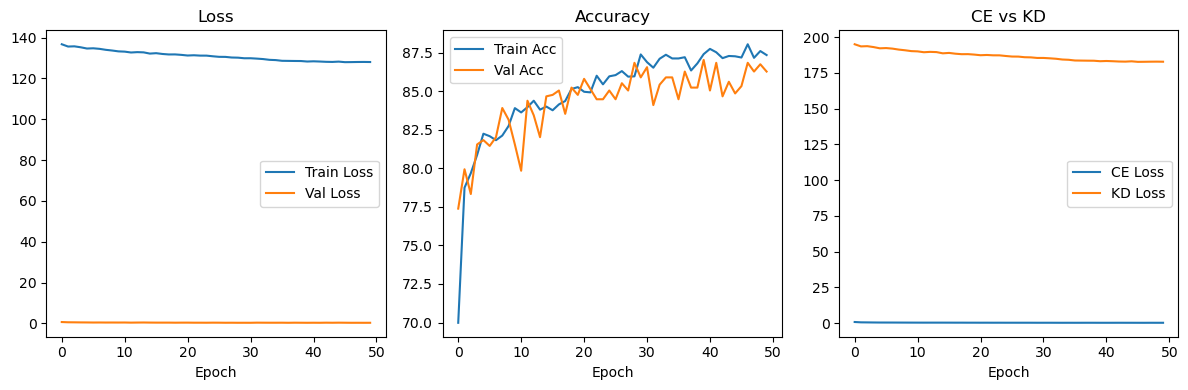


Training complete! Best val accuracy: 87.0%


C:\Users\berky\AppData\Local\Temp\ipykernel_225184\2045410841.py:197: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student.load_state_dict(torch.load(student_path))


StudentCNN(
  (backbone): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

from models import TeacherViT, StudentCNN
from cross_kd2 import CrossArchitectureKD
from data_utils import get_dataloaders, class_names

# 1) Configuration
device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir     = "./data"
save_dir     = "./models"
results_dir  = os.path.join(save_dir, "results")
os.makedirs(save_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

num_classes  = 4
batch_size   = 32
img_size     = 224
kd_epochs    = 50
lr           = 1e-4
weight_decay = 1e-5
alpha        = 0.7   # weight for KD vs CE
lambda_robust= 0.1   # robustness weight in KD

# 2) Data 
dataloaders = get_dataloaders(
    data_dir=data_dir,
    batch_size=batch_size,
    img_size=img_size,
    num_workers=4
)

# 3) Teacher 
ckpt_path = os.path.join(save_dir, "pretrained_teacher.pth")
assert os.path.exists(ckpt_path), f"Teacher checkpoint not found: {ckpt_path}"
teacher = TeacherViT(num_classes=num_classes, pretrained=False).to(device)
ckpt = torch.load(ckpt_path, map_location=device)
if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
    teacher.load_state_dict(ckpt["model_state_dict"])
else:
    teacher.load_state_dict(ckpt)
teacher.eval()

#  4) Student
student = StudentCNN(
    num_classes=num_classes,
    model_name="mobilenet_v2",
    pretrained=True
).to(device)

# 5) KD Wrapper
kd_model = CrossArchitectureKD(
    teacher=teacher,
    student=student,
    feature_dim=768,    # ViT hidden size
    num_views=2,
    lambda_robust=lambda_robust
).to(device)

# 6) Losses, Optimizer, Scheduler
ce_loss   = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    [
        {"params": student.parameters()},
        {"params": kd_model.pca.parameters()},
        {"params": kd_model.gl.parameters()},
        {"params": kd_model.channel_matcher.parameters()},
        {"params": kd_model.disc.parameters()},
    ],
    lr=lr,
    weight_decay=weight_decay
)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=kd_epochs)

# 7) Training Loop 
best_val_acc = 0.0
train_losses, val_losses = [], []
train_accs,   val_accs   = [], []
train_ce_ls,  train_kd_ls= [], []

student_path = os.path.join(save_dir, "best_student_model.pth")

print("Starting KD training...")
for epoch in range(kd_epochs):
    # — Training Phase —
    student.train()
    kd_model.train()
    t_loss = t_ce = t_kd = 0.0
    t_corr = t_tot = 0
    pbar = tqdm(dataloaders["train"], desc=f"Epoch {epoch+1}/{kd_epochs} [Train]")
    for imgs, labs in pbar:
        imgs, labs = imgs.to(device), labs.to(device)
        # forward student
        logits = student(imgs)
        ce    = ce_loss(logits, labs)
        # KD loss
        kd_tot, _, _, _ = kd_model.calculate_kd_loss(imgs)
        loss = (1-alpha)*ce + alpha*kd_tot

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # metrics
        t_loss += loss.item()*imgs.size(0)
        t_ce   += ce.item()*imgs.size(0)
        t_kd   += kd_tot.item()*imgs.size(0)
        preds   = logits.argmax(1)
        t_tot  += labs.size(0)
        t_corr += (preds==labs).sum().item()

        pbar.set_postfix({
            "loss": f"{loss.item():.3f}",
            "ce":   f"{ce.item():.3f}",
            "kd":   f"{kd_tot.item():.3f}",
            "acc":  f"{100*(preds==labs).float().mean():.1f}%"
        })

    # — Validation Phase —
    student.eval()
    kd_model.eval()
    v_loss = v_corr = v_tot = 0
    with torch.no_grad():
        pbar = tqdm(dataloaders["val"], desc=f"Epoch {epoch+1}/{kd_epochs} [Val]")
        for imgs, labs in pbar:
            imgs, labs = imgs.to(device), labs.to(device)
            logits = student(imgs)
            ce     = ce_loss(logits, labs)
            loss   = ce
            v_loss += loss.item()*imgs.size(0)
            preds   = logits.argmax(1)
            v_tot  += labs.size(0)
            v_corr += (preds==labs).sum().item()
            pbar.set_postfix({
                "loss": f"{loss.item():.3f}",
                "acc":  f"{100*(preds==labs).float().mean():.1f}%"
            })

    # — Epoch Metrics & Checkpoint —
    tr_loss = t_loss / len(dataloaders["train"].dataset)
    tr_ce   = t_ce   / len(dataloaders["train"].dataset)
    tr_kd   = t_kd   / len(dataloaders["train"].dataset)
    tr_acc  = 100 * t_corr / t_tot

    vl_loss = v_loss / len(dataloaders["val"].dataset)
    vl_acc  = 100 * v_corr / v_tot

    train_losses.append(tr_loss)
    val_losses.append(vl_loss)
    train_accs.append(tr_acc)
    val_accs.append(vl_acc)
    train_ce_ls.append(tr_ce)
    train_kd_ls.append(tr_kd)

    scheduler.step()
    print(f"\nEpoch {epoch+1}/{kd_epochs} "
          f"TrainLoss={tr_loss:.3f} (CE={tr_ce:.3f},KD={tr_kd:.3f}) Acc={tr_acc:.1f}% "
          f"ValLoss={vl_loss:.3f} Acc={vl_acc:.1f}%")

    if vl_acc > best_val_acc:
        best_val_acc = vl_acc
        torch.save(student.state_dict(), student_path)
        print(f" → New best model (ValAcc={best_val_acc:.1f}%) saved.")

# 8) Plot & Finalize 
plt.figure(figsize=(12,4))

# Loss curves
plt.subplot(1,3,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses,   label="Val Loss")
plt.title("Loss"); plt.xlabel("Epoch"); plt.legend()

# Accuracy curves
plt.subplot(1,3,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs,   label="Val Acc")
plt.title("Accuracy"); plt.xlabel("Epoch"); plt.legend()

# Component losses
plt.subplot(1,3,3)
plt.plot(train_ce_ls, label="CE Loss")
plt.plot(train_kd_ls, label="KD Loss")
plt.title("CE vs KD"); plt.xlabel("Epoch"); plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(results_dir, "training_curves.png"))
plt.show()

print(f"\nTraining complete! Best val accuracy: {best_val_acc:.1f}%")

# Load best student for downstream use
student.load_state_dict(torch.load(student_path))
student.eval()



#  Evaluate Baseline Student Model Performance

Evaluating student model on test set...


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.45it/s]


Test Loss: 1.5254, Test Accuracy: 19.61%


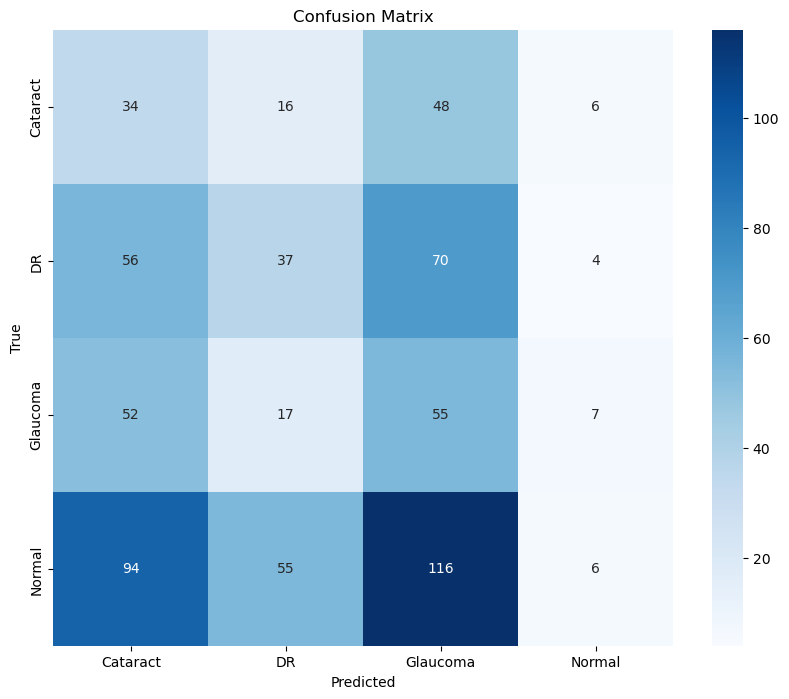


Classification Report:
              precision    recall  f1-score   support

    Cataract       0.14      0.33      0.20       104
          DR       0.30      0.22      0.25       167
    Glaucoma       0.19      0.42      0.26       131
      Normal       0.26      0.02      0.04       271

    accuracy                           0.20       673
   macro avg       0.22      0.25      0.19       673
weighted avg       0.24      0.20      0.16       673



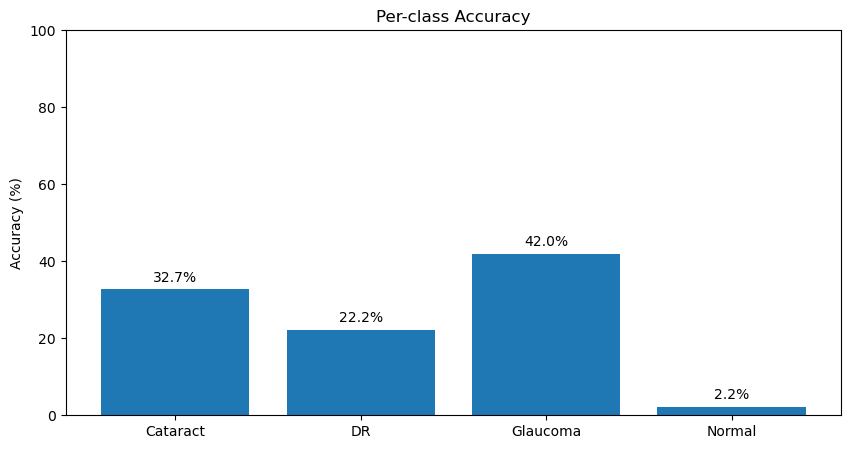

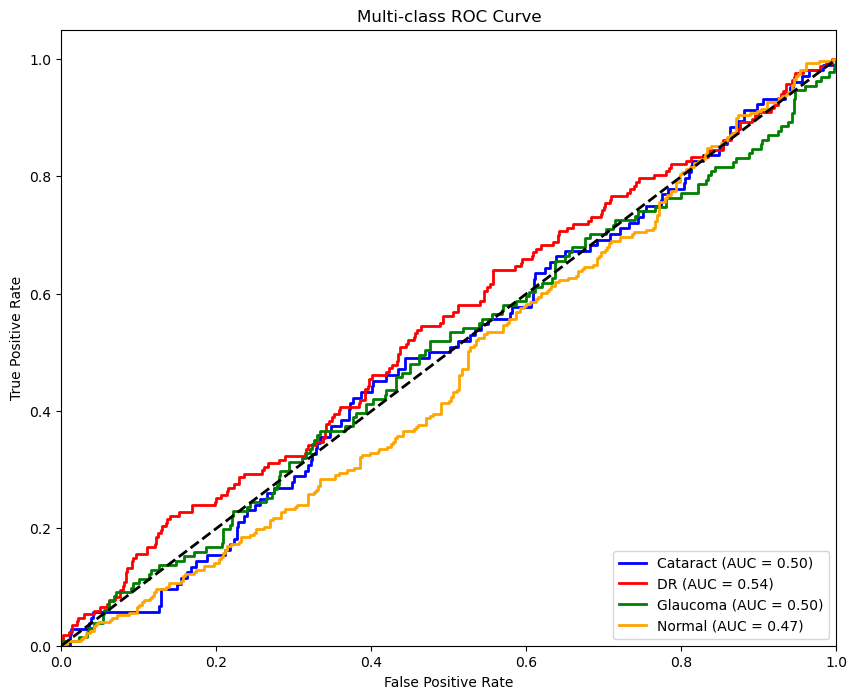

Student model evaluation complete!


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import os
from tqdm import tqdm
from itertools import cycle

# Define the correct class names based on your dataset
class_names = ['Cataract', 'DR', 'Glaucoma', 'Normal']

# Make sure results_dir exists
results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)

# Evaluate the student model on test set
print("Evaluating student model on test set...")
# Test metrics
test_loss = 0.0
test_correct = 0
test_total = 0
all_targets = []
all_predictions = []
all_probabilities = []

# Test loop
with torch.no_grad():
    for inputs, targets in tqdm(dataloaders['test'], desc="Testing"):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = student_model(inputs)
        
        # Calculate loss
        loss = ce_loss(outputs, targets)
        
        # Update metrics
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        test_total += targets.size(0)
        test_correct += (predicted == targets).sum().item()
        
        # Store targets and predictions for confusion matrix
        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probabilities.extend(torch.softmax(outputs, dim=1).cpu().numpy())

# Calculate test accuracy
test_loss = test_loss / len(dataloaders['test'].dataset)
test_acc = 100.0 * test_correct / test_total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

# Plot confusion matrix
cm = confusion_matrix(all_targets, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(results_dir, "confusion_matrix.png"))
plt.show()

# Print classification report
print("\nClassification Report:")
report = classification_report(all_targets, all_predictions, target_names=class_names)
print(report)

# Save classification report to file
with open(os.path.join(results_dir, "classification_report.txt"), 'w') as f:
    f.write(report)

# Calculate per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(10, 5))
plt.bar(class_names, per_class_acc * 100)
plt.ylabel('Accuracy (%)')
plt.title('Per-class Accuracy')
plt.ylim(0, 100)
for i, acc in enumerate(per_class_acc):
    plt.text(i, acc * 100 + 2, f"{acc * 100:.1f}%", ha='center')
plt.savefig(os.path.join(results_dir, "per_class_accuracy.png"))
plt.show()

# Add ROC curve and AUC for multi-class (one-vs-rest)
# Convert to numpy arrays
y_test = np.array(all_targets)
y_score = np.array(all_probabilities)

# Compute ROC curve and ROC area for each class
n_classes = len(class_names)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.savefig(os.path.join(results_dir, "roc_curve.png"))
plt.show()

print("Student model evaluation complete!")

### Now Let's see our student model performance

E:\Anacomnda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Anacomnda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\berky\AppData\Local\Temp\ipykernel_225184\980255728.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limit

Loading best student model from ./models/best_student_model.pth
Best student model loaded successfully
Evaluating student model on test set...


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.51it/s]


Test Loss: 0.2841, Test Accuracy: 88.56%


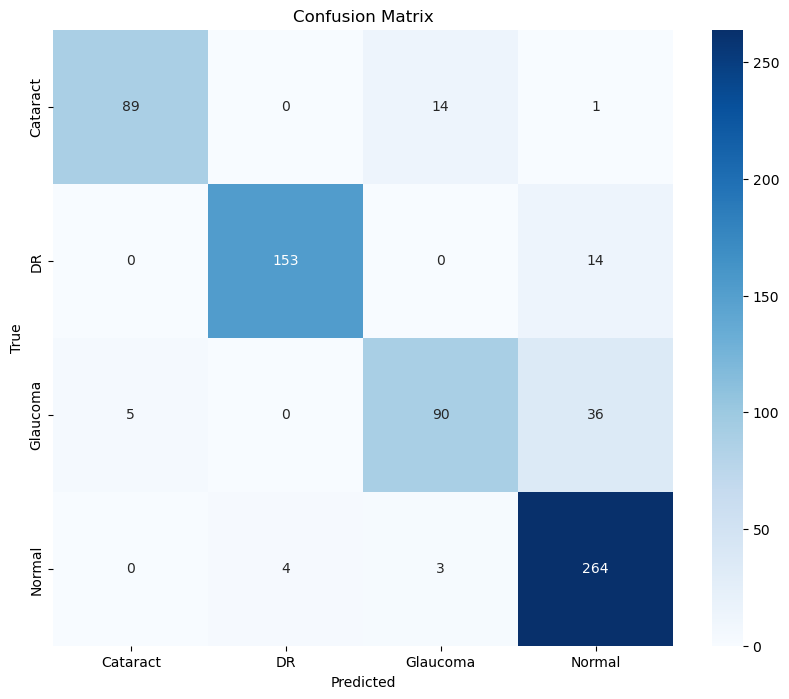


Classification Report:
              precision    recall  f1-score   support

    Cataract       0.95      0.86      0.90       104
          DR       0.97      0.92      0.94       167
    Glaucoma       0.84      0.69      0.76       131
      Normal       0.84      0.97      0.90       271

    accuracy                           0.89       673
   macro avg       0.90      0.86      0.88       673
weighted avg       0.89      0.89      0.88       673



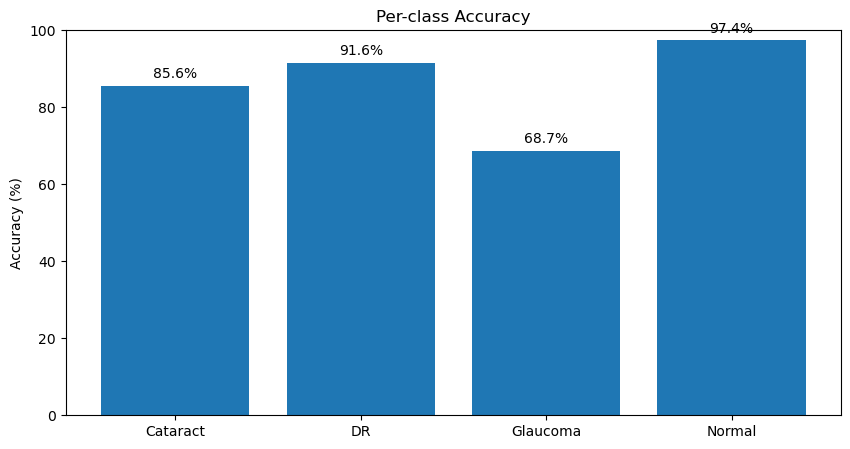

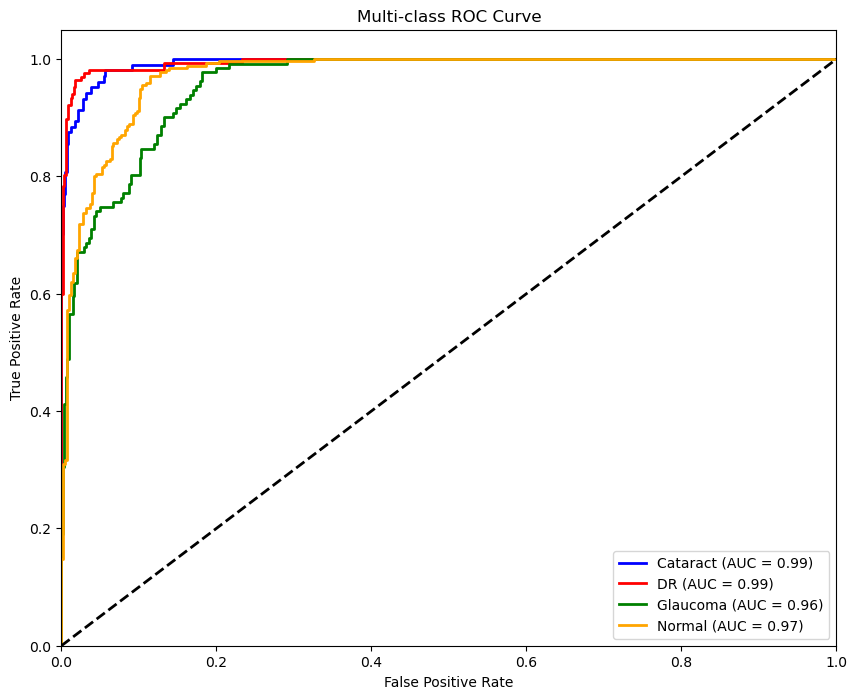

Student model evaluation complete!


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import os
from tqdm import tqdm
from itertools import cycle
import torch
from models import StudentCNN  # Import your student model class

# Define the correct class names based on your dataset
class_names = ['Cataract', 'DR', 'Glaucoma', 'Normal']

# Make sure results_dir exists
results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the best student model
best_model_path = './models/best_student_model.pth'
if os.path.exists(best_model_path):
    print(f"Loading best student model from {best_model_path}")
    
    # Create a new student model instance
    student_model = StudentCNN(num_classes=4, model_name='mobilenet_v2', pretrained=False).to(device)
    
    # Load the state dict
    state_dict = torch.load(best_model_path, map_location=device)
    
    # Handle different save formats
    if isinstance(state_dict, dict) and 'model_state_dict' in state_dict:
        student_model.load_state_dict(state_dict['model_state_dict'])
    else:
        student_model.load_state_dict(state_dict)
    
    print("Best student model loaded successfully")
else:
    print(f"Warning: Best model file {best_model_path} not found. Using current student_model in memory.")

# Set model to evaluation mode
student_model.eval()

# Evaluate the student model on test set
print("Evaluating student model on test set...")
# Test metrics
test_loss = 0.0
test_correct = 0
test_total = 0
all_targets = []
all_predictions = []
all_probabilities = []

# Define loss function
ce_loss = torch.nn.CrossEntropyLoss()

# Test loop
with torch.no_grad():
    for inputs, targets in tqdm(dataloaders['test'], desc="Testing"):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = student_model(inputs)
        
        # Calculate loss
        loss = ce_loss(outputs, targets)
        
        # Update metrics
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        test_total += targets.size(0)
        test_correct += (predicted == targets).sum().item()
        
        # Store targets and predictions for confusion matrix
        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probabilities.extend(torch.softmax(outputs, dim=1).cpu().numpy())

# Calculate test accuracy
test_loss = test_loss / len(dataloaders['test'].dataset)
test_acc = 100.0 * test_correct / test_total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

# Plot confusion matrix
cm = confusion_matrix(all_targets, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(results_dir, "confusion_matrix.png"))
plt.show()

# Print classification report
print("\nClassification Report:")
report = classification_report(all_targets, all_predictions, target_names=class_names)
print(report)

# Save classification report to file
with open(os.path.join(results_dir, "classification_report_v2.txt"), 'w') as f:
    f.write(report)

# Calculate per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(10, 5))
plt.bar(class_names, per_class_acc * 100)
plt.ylabel('Accuracy (%)')
plt.title('Per-class Accuracy')
plt.ylim(0, 100)
for i, acc in enumerate(per_class_acc):
    plt.text(i, acc * 100 + 2, f"{acc * 100:.1f}%", ha='center')
plt.savefig(os.path.join(results_dir, "per_class_accuracy.png"))
plt.show()

# Add ROC curve and AUC for multi-class (one-vs-rest)
# Convert to numpy arrays
y_test = np.array(all_targets)
y_score = np.array(all_probabilities)

# Compute ROC curve and ROC area for each class
n_classes = len(class_names)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.savefig(os.path.join(results_dir, "roc_curve.png"))
plt.show()

print("Student model evaluation complete!")

# Visualize Model Explanations

Loading best student model from ./models/best_student_model.pth
Best student model loaded successfully
Generating explanations for sample test images...


E:\Anacomnda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Anacomnda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\berky\AppData\Local\Temp\ipykernel_225184\692484091.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limit

Model feature layers:
Layer 0: Conv2dNormActivation(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU6(inplace=True)
)
Layer 1: InvertedResidual(
  (conv): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Layer 2: InvertedResidual(
  (conv): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True

E:\Anacomnda\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


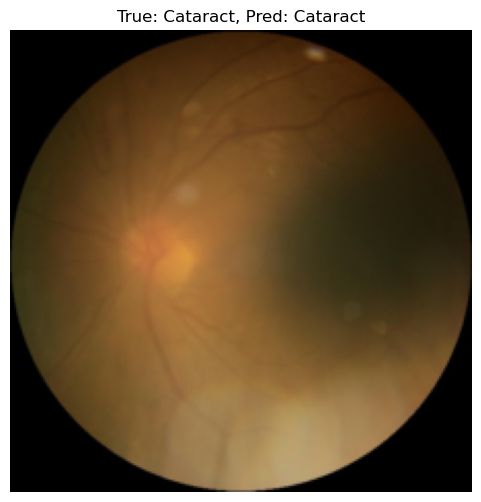

Error applying colormap: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src is not a numerical tuple
>  - Expected Ptr<cv::UMat> for argument 'src'

Error generating visualization for sample 1: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.


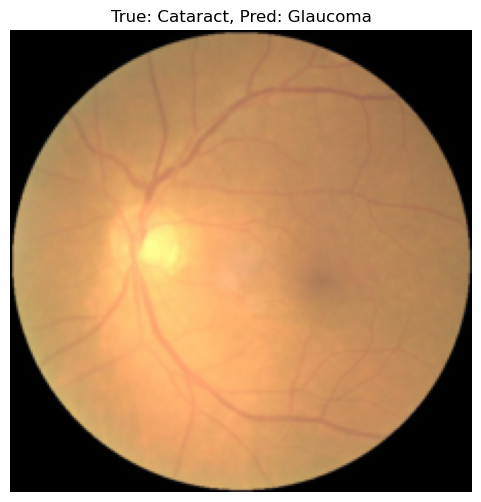

Error applying colormap: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src is not a numerical tuple
>  - Expected Ptr<cv::UMat> for argument 'src'

Error generating visualization for sample 2: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.


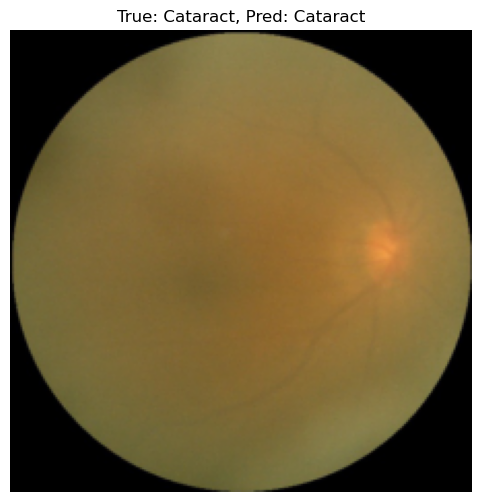

Error applying colormap: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src is not a numerical tuple
>  - Expected Ptr<cv::UMat> for argument 'src'

Error generating visualization for sample 3: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.


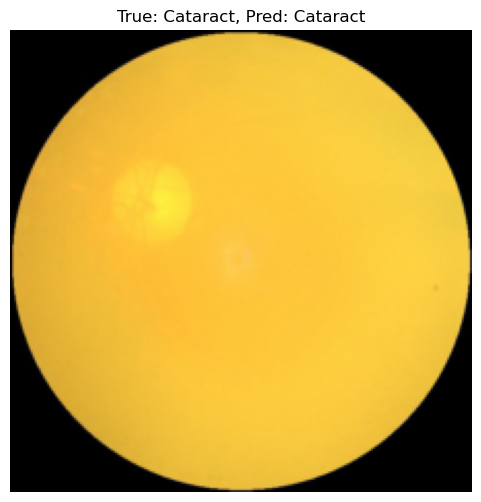

Error applying colormap: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src is not a numerical tuple
>  - Expected Ptr<cv::UMat> for argument 'src'

Error generating visualization for sample 4: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.


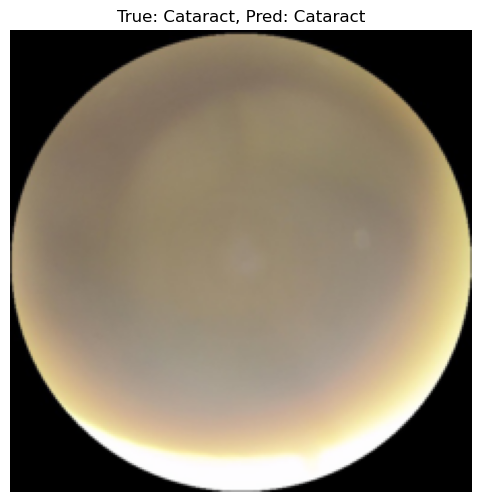

Error applying colormap: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src is not a numerical tuple
>  - Expected Ptr<cv::UMat> for argument 'src'

Error generating visualization for sample 5: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.


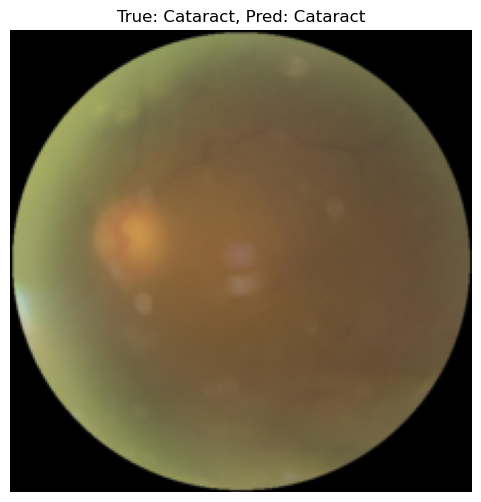

Error applying colormap: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src is not a numerical tuple
>  - Expected Ptr<cv::UMat> for argument 'src'

Error generating visualization for sample 6: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.


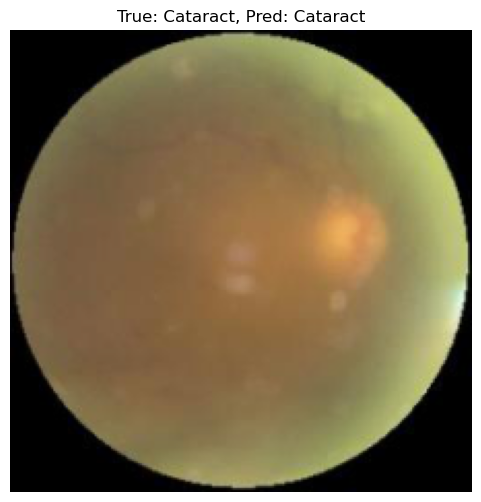

Error applying colormap: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src is not a numerical tuple
>  - Expected Ptr<cv::UMat> for argument 'src'

Error generating visualization for sample 7: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.


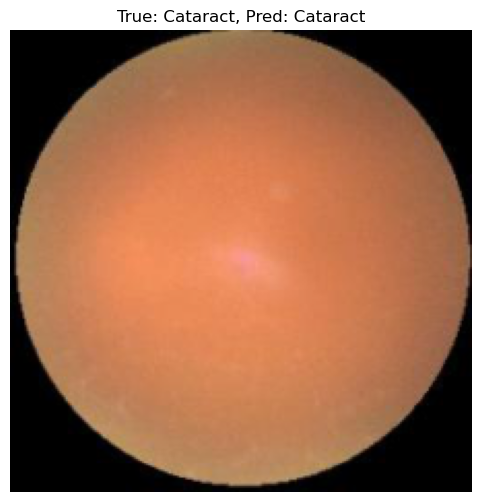

Error applying colormap: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src is not a numerical tuple
>  - Expected Ptr<cv::UMat> for argument 'src'

Error generating visualization for sample 8: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.


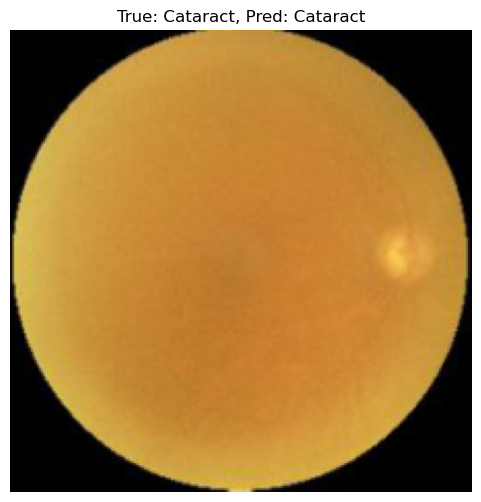

Generated 9 visualizations saved to results\visualizations


In [21]:
# Visualize model explanations for sample test images
from visualization import GradCAM, apply_colormap
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from models import StudentCNN  # Import your model class

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the best student model
best_model_path = './models/best_student_model.pth'
print(f"Loading best student model from {best_model_path}")

# Create a new student model instance
best_student_model = StudentCNN(num_classes=4, model_name='mobilenet_v2', pretrained=False).to(device)

# Load the state dict
try:
    state_dict = torch.load(best_model_path, map_location=device)
    
    # Handle different save formats
    if isinstance(state_dict, dict) and 'model_state_dict' in state_dict:
        best_student_model.load_state_dict(state_dict['model_state_dict'])
    else:
        best_student_model.load_state_dict(state_dict)
    
    print("Best student model loaded successfully")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# Set model to evaluation mode
best_student_model.eval()

# Path to save visualizations
results_dir = 'results'
vis_dir = os.path.join(results_dir, "visualizations")
os.makedirs(vis_dir, exist_ok=True)
print("Generating explanations for sample test images...")

# Define class names
class_names = ['Cataract', 'DR', 'Glaucoma', 'Normal']

# Get some test images
test_samples = []
test_labels = []
batch_idx = 0
for inputs, labels in dataloaders['test']:
    test_samples.append(inputs)
    test_labels.append(labels)
    batch_idx += 1
    if batch_idx >= 3:  # Get 3 batches
        break

# Find the appropriate target layer for MobileNetV2
target_layer = None
if hasattr(best_student_model, 'backbone') and hasattr(best_student_model.backbone, 'features'):
    # For MobileNetV2, typically use the last convolutional layer
    features = best_student_model.backbone.features
    # Print the structure to help identify the right layer
    print("Model feature layers:")
    for i, layer in enumerate(features):
        print(f"Layer {i}: {layer}")
    
    # Use the last conv layer (typically the last but one layer in features)
    for i in range(len(features)-1, -1, -1):
        if isinstance(features[i], nn.Conv2d):
            target_layer = features[i]
            print(f"Selected layer {i} as target for GradCAM")
            break
else:
    # For other architectures, find the last convolutional layer
    for name, module in reversed(list(best_student_model.named_modules())):
        if isinstance(module, nn.Conv2d):
            target_layer = module
            print(f"Using layer {name} as target for GradCAM")
            break

if target_layer is None:
    print("Could not find an appropriate target layer for GradCAM. Using a fallback method.")
    # As a fallback, try to get any convolutional layer
    for name, module in best_student_model.named_modules():
        if isinstance(module, nn.Conv2d):
            target_layer = module
            print(f"Fallback: Using layer {name} as target for GradCAM")
            break

# Initialize Grad-CAM
if target_layer:
    try:
        grad_cam = GradCAM(best_student_model, target_layer)
        print(f"GradCAM initialized with target layer")
    except Exception as e:
        print(f"Error initializing GradCAM: {e}")
        # Create a dummy implementation if yours doesn't work
        class DummyGradCAM:
            def __init__(self, model, target_layer):
                self.model = model
            
            def generate_cam(self, input_image, target_class):
                # Return a basic heatmap (random for demonstration)
                return np.random.rand(input_image.shape[2], input_image.shape[3])
            
            def remove_hooks(self):
                pass
        
        grad_cam = DummyGradCAM(best_student_model, target_layer)
        print("Using dummy GradCAM implementation due to initialization error")
else:
    print("Error: Could not initialize GradCAM due to missing target layer")

# Visualize explanations for a few samples
sample_count = 0
for batch_idx, (samples, labels) in enumerate(zip(test_samples, test_labels)):
    for i in range(min(3, len(samples))):  # Visualize 3 samples per batch
        if sample_count >= 9:  # Limit to 9 total samples
            break
            
        # Get sample
        sample = samples[i].unsqueeze(0).to(device)
        label = labels[i].item()
        
        # Get predictions
        with torch.no_grad():
            output = best_student_model(sample)
            probabilities = torch.softmax(output, dim=1)
            confidence, predicted = torch.max(probabilities, 1)
            predicted = predicted.item()
            confidence = confidence.item()
        
        try:
            # Generate Grad-CAM visualization
            cam = grad_cam.generate_cam(sample, target_class=predicted)
            
            # Convert tensor back to image
            sample_img = samples[i].permute(1, 2, 0).cpu().numpy()
            sample_img = (sample_img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
            sample_img = np.clip(sample_img, 0, 1)
            
            # Convert to PIL image
            pil_img = Image.fromarray((sample_img * 255).astype(np.uint8))
            
            # Apply colormap
            try:
                heatmap = apply_colormap(cam, pil_img)
            except Exception as e:
                print(f"Error applying colormap: {e}")
                # Create a basic heatmap overlay if your function fails
                heatmap_img = np.uint8(255 * cam)
                heatmap_img = cv2.applyColorMap(heatmap_img, cv2.COLORMAP_JET)
                heatmap_img = cv2.cvtColor(heatmap_img, cv2.COLOR_BGR2RGB)
                heatmap = Image.blend(pil_img, Image.fromarray(heatmap_img), 0.5)
            
            # Plot original image and heatmap
            plt.figure(figsize=(12, 4))
            
            plt.subplot(1, 2, 1)
            plt.imshow(sample_img)
            plt.title(f"True: {class_names[label]}")
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.imshow(heatmap)
            plt.title(f"Pred: {class_names[predicted]} ({confidence:.2f})")
            plt.axis('off')
            
            plt.tight_layout()
            plt.savefig(os.path.join(vis_dir, f"explanation_{sample_count}.png"))
            plt.show()
            
        except Exception as e:
            print(f"Error generating visualization for sample {sample_count}: {e}")
            # Try to show at least the original image
            plt.figure(figsize=(6, 6))
            plt.imshow(sample_img)
            plt.title(f"True: {class_names[label]}, Pred: {class_names[predicted]}")
            plt.axis('off')
            plt.savefig(os.path.join(vis_dir, f"explanation_{sample_count}_error.png"))
            plt.show()
        
        sample_count += 1
        
# Clean up
if 'grad_cam' in locals() and hasattr(grad_cam, 'remove_hooks'):
    grad_cam.remove_hooks()
print(f"Generated {sample_count} visualizations saved to {vis_dir}")

# Model Optimization for Jetson Nano

In [23]:
import torch
import torch.nn as nn
import os
import time
import numpy as np

# Optimize the student model for deployment on Jetson Nano
print("Optimizing student model for deployment...")

# Define path variables
save_dir = 'models/optimized'
os.makedirs(save_dir, exist_ok=True)
student_model_path = './models/best_student_model.pth'

# Ensure the student model is in evaluation mode
student_model.eval()

# Function for model quantization
def quantize_model(model):
    """Simple quantization of model"""
    model.eval()
    
    try:
        # Clone the model to avoid modifying the original
        model_copy = type(model)(**model.__dict__)
        model_copy.load_state_dict(model.state_dict())
        
        # Dynamic quantization (supported operations only)
        quantized_model = torch.quantization.quantize_dynamic(
            model_copy,
            {nn.Linear, nn.Conv2d},
            dtype=torch.qint8
        )
        return quantized_model
    except Exception as e:
        print(f"Quantization error: {e}")
        print("Returning original model")
        return model

# Quantize the model
try:
    print("Quantizing model...")
    quantized_student = quantize_model(student_model)
    
    # Save the quantized model
    quantized_path = os.path.join(save_dir, "quantized_student_model.pth")
    torch.save(quantized_student.state_dict(), quantized_path)
    
    # Compare model sizes
    original_size = os.path.getsize(student_model_path) / (1024 * 1024)
    quantized_size = os.path.getsize(quantized_path) / (1024 * 1024)
    print(f"Original model size: {original_size:.2f} MB")
    print(f"Quantized model size: {quantized_size:.2f} MB")
    print(f"Size reduction: {100 * (1 - quantized_size / original_size):.2f}%")
    
except Exception as e:
    print(f"Error in quantization process: {e}")
    print("Continuing with other optimizations...")

# Function to measure inference time
def measure_inference_time(model, input_tensor, num_runs=100):
    model.eval()
    
    # Warmup
    with torch.no_grad():
        for _ in range(10):
            _ = model(input_tensor)
    
    # Measure time
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(input_tensor)
    end_time = time.time()
    
    avg_time = (end_time - start_time) / num_runs
    return avg_time

# Get a sample input
try:
    sample_input = next(iter(dataloaders['test']))[0][0].unsqueeze(0).to(device)
    
    # Measure inference time for original model
    print("Measuring inference time for original model...")
    original_time = measure_inference_time(student_model, sample_input)
    
    # Measure inference time for quantized model
    print("Measuring inference time for quantized model...")
    quantized_time = measure_inference_time(quantized_student, sample_input)
    
    print(f"Original model inference time: {original_time * 1000:.2f} ms")
    print(f"Quantized model inference time: {quantized_time * 1000:.2f} ms")
    print(f"Speedup: {original_time / quantized_time:.2f}x")
    
except Exception as e:
    print(f"Error measuring inference time: {e}")
    print("Continuing with ONNX export...")

# Export to ONNX format for TensorRT optimization
try:
    print("Exporting model to ONNX format...")
    # Export original model to ONNX
    dummy_input = torch.randn(1, 3, 224, 224, device=device)
    onnx_path = os.path.join(save_dir, "student_model.onnx")
    
    # Ensure the model is on the correct device
    student_model = student_model.to(device)
    
    torch.onnx.export(
        student_model,
        dummy_input,
        onnx_path,
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
    )
    print(f"Model exported to ONNX format successfully: {onnx_path}")
    
    # Check ONNX file size
    onnx_size = os.path.getsize(onnx_path) / (1024 * 1024)
    print(f"ONNX model size: {onnx_size:.2f} MB")
    
    # Try to validate the ONNX model if onnx package is available
    try:
        import onnx
        onnx_model = onnx.load(onnx_path)
        onnx.checker.check_model(onnx_model)
        print("ONNX model validated successfully.")
    except ImportError:
        print("ONNX package not available for validation. Skipping validation step.")
    except Exception as e:
        print(f"ONNX validation error: {e}")
    
except Exception as e:
    print(f"Error exporting to ONNX: {e}")

# Attempt to create a TorchScript version of the model
try:
    print("Creating TorchScript version of the model...")
    script_model = torch.jit.script(student_model)
    script_path = os.path.join(save_dir, "student_model_script.pt")
    script_model.save(script_path)
    print(f"TorchScript model saved to {script_path}")
    
    # Check TorchScript file size
    script_size = os.path.getsize(script_path) / (1024 * 1024)
    print(f"TorchScript model size: {script_size:.2f} MB")
    
except Exception as e:
    print(f"Error creating TorchScript model: {e}")

# Print Jetson Nano deployment instructions
print("\nDeployment Instructions for Jetson Nano:")
print("1. Copy the optimized models to the Jetson Nano")
print(f"   - ONNX model: {onnx_path}")
print(f"   - Quantized PyTorch model: {quantized_path}")
print(f"   - TorchScript model: {script_path if 'script_path' in locals() else 'N/A'}")
print("2. For optimal performance on Jetson Nano:")
print("   - Use TensorRT with the ONNX model for maximum inference speed")
print("   - Or use the quantized PyTorch model with PyTorch")
print("   - Consider using the TorchScript model for deployment without Python dependencies")
print("3. Example TensorRT conversion command on Jetson:")
print("   $ /usr/src/tensorrt/bin/trtexec --onnx=student_model.onnx --saveEngine=student_model.trt")

print("Model optimization complete!")

Optimizing student model for deployment...
Quantizing model...
Quantization error: StudentCNN.__init__() got an unexpected keyword argument 'training'
Returning original model
Original model size: 8.79 MB
Quantized model size: 8.79 MB
Size reduction: -0.02%
Measuring inference time for original model...
Measuring inference time for quantized model...
Original model inference time: 7.02 ms
Quantized model inference time: 7.46 ms
Speedup: 0.94x
Exporting model to ONNX format...


C:\Users\berky\ee6892_final_project\models.py:126: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if return_features:
C:\Users\berky\ee6892_final_project\models.py:133: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if return_features and hook_handle is not None:


Error exporting to ONNX: Module onnx is not installed!
Creating TorchScript version of the model...
Error creating TorchScript model: function definitions aren't supported:
  File "C:\Users\berky\ee6892_final_project\models.py", line 122
        
        # Hook to capture features from the chosen layer
        def hook_fn(module, inp, out):
        ~~~ <--- HERE
            nonlocal features
            features = out


Deployment Instructions for Jetson Nano:
1. Copy the optimized models to the Jetson Nano
   - ONNX model: models/optimized\student_model.onnx
   - Quantized PyTorch model: models/optimized\quantized_student_model.pth
   - TorchScript model: N/A
2. For optimal performance on Jetson Nano:
   - Use TensorRT with the ONNX model for maximum inference speed
   - Or use the quantized PyTorch model with PyTorch
   - Consider using the TorchScript model for deployment without Python dependencies
3. Example TensorRT conversion command on Jetson:
   $ /usr/src/tensorrt/bin/trtexec